# Flower Classification using ResNet-50 Model

### Importing Dependencies

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.get_device_details(gpus[0])

{'compute_capability': (6, 1), 'device_name': 'NVIDIA GeForce GTX 1070'}

### Load Flower Dataset
Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset

No. of Classes: 5

Classes: Lilly, Lotus, Orchid, Sunflower, Tulip

Total Images: 5000 

In [2]:
input_shape = (224, 224, 3)
image_shape = (224, 224)
num_classes = 5
batch_size = 8

train_data, val_data = keras.utils.image_dataset_from_directory('flower_images', batch_size=batch_size, image_size=image_shape, label_mode='categorical', seed=225, validation_split= 0.2, subset='both')

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Using 999 files for validation.


### Model Definition(ResNet-50)



#### ResNet Block

In [3]:
def resnet_block(filters, prev, index):
    x = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(prev)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters=filters * 4, kernel_size=1, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x0 = keras.layers.ReLU()(x)
    
    
    if index == 0:
        x = keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1, padding='same')(prev)
        x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.add([x, x0])
    
    else:
        x = keras.layers.add([prev, x])
    
    x = keras.layers.ReLU()(x)
    
    return x


#### Model

In [4]:
input = keras.Input(shape=input_shape)

x = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

for i in range(3):
    x = resnet_block(64, x, i)

for i in range(4):
    x = resnet_block(128, x, i)
    
for i in range(6):
    x = resnet_block(256, x, i)
    
for i in range(3):
    x = resnet_block(512, x, i)

# Classifier
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
output = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

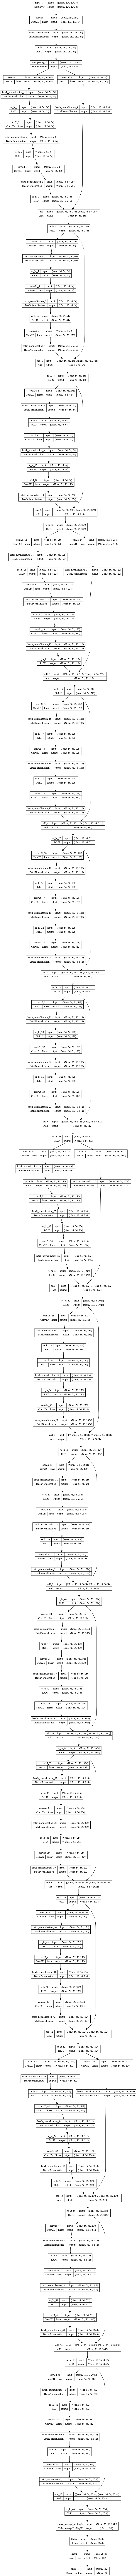

In [5]:
keras.utils.plot_model(model, to_file='model_architectures/resnet-50.png', expand_nested=True, show_layer_activations=True, show_shapes=True)

In [6]:
# Counting Conv2D layers
conv_layers = 0
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        conv_layers += 1
f'Total no. of Conv2D Layers: {conv_layers}'

'Total no. of Conv2D Layers: 53'

### Model Training

In [7]:
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr / 10
    else:
        return lr
    
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.LearningRateScheduler(lr_schedule), 
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/resnet-50.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [9]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_data, epochs=25, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose='auto')

Epoch 1/25
500/500 [==============================] - 583s 1s/step - loss: 1.4190 - accuracy: 0.3950 - val_loss: 1.6674 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 2/25
500/500 [==============================] - 556s 1s/step - loss: 1.2965 - accuracy: 0.4688 - val_loss: 1.2098 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 3/25
500/500 [==============================] - 556s 1s/step - loss: 1.2349 - accuracy: 0.5073 - val_loss: 1.0937 - val_accuracy: 0.5566 - lr: 0.0010
Epoch 4/25
500/500 [==============================] - 555s 1s/step - loss: 1.1812 - accuracy: 0.5203 - val_loss: 1.2070 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 5/25
500/500 [==============================] - 555s 1s/step - loss: 1.1630 - accuracy: 0.5397 - val_loss: 1.0768 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 6/25
500/500 [==============================] - 556s 1s/step - loss: 1.1382 - accuracy: 0.5470 - val_loss: 1.2833 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 7/25
500/500 [==============================] - 556s 1s/st

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'loss')]

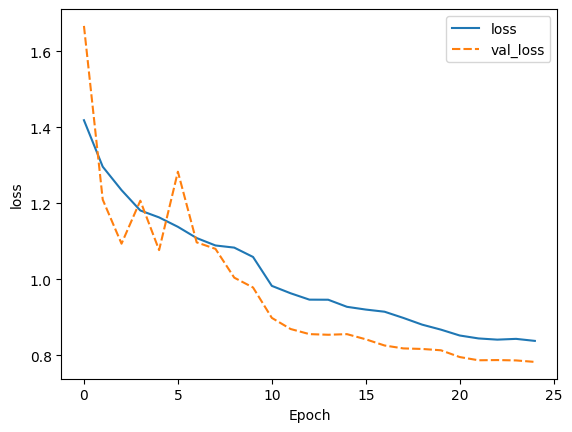

In [10]:
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
ax.set(xlabel='Epoch', ylabel='loss')

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy')]

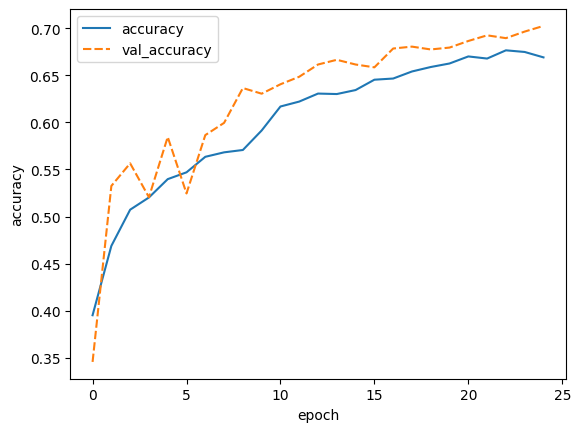

In [11]:
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})
ax.set(xlabel='epoch', ylabel='accuracy')